# 网络犯罪文本分析

本案例数据集较为丰富,包含文本变量与分类变量,目前仅对"当事人信息"与"事实"两文本变量进行了LDA分析建模,并与词向量模型进行了比较,后续仍待继续完善.  
另外,当前代码略显臃肿,部分模块如封装会更方便调用.

## 1. 数据预处理

In [2]:
import pandas as pd
import numpy as np

In [682]:
data0 = pd.read_csv('2016_2020_net_crime.csv',infer_datetime_format=True)

In [685]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1862 entries, 0 to 1861
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   案号           1861 non-null   object 
 1   省份           1861 non-null   object 
 2   罪名           1861 non-null   object 
 3   法院名称         1861 non-null   object 
 4   审级           1861 non-null   object 
 5   立案时间         1781 non-null   object 
 6   结案时间         1861 non-null   object 
 7   文书类型         1861 non-null   object 
 8   适用程序         1861 non-null   object 
 9   当事人信息        1837 non-null   object 
 10  审理查明         1656 non-null   object 
 11  本院认为         1853 non-null   object 
 12  判决结果         1831 non-null   object 
 13  适用法条         1841 non-null   object 
 14  Unnamed: 14  0 non-null      float64
dtypes: float64(1), object(14)
memory usage: 218.3+ KB


In [5]:
data = data0.iloc[:,:-1]
for col in data.columns:
    data[col] = data[col].astype('string')

In [6]:
fact = []
for x,y in zip(data['审理查明'],data['本院认为']):
    if not pd.isnull(x) & (not pd.isnull(y)):
        z = (x+y) #字符串拼接有个bug是,如果两个其中一个缺失,那z也缺失,这里也先不要强制str,否则下面判断不出缺失
    else:
        xylist = [x,y]
        z = (xylist[np.where(pd.isnull(xylist)==0)[0].tolist()[0]])        
    fact.append(z)

In [7]:
data['事实'] = fact
data.drop(['审理查明','本院认为'],axis=1,inplace=True)
data.drop(np.where(data['事实'].isna()==1)[0],axis=0,inplace = True)
data = data.reset_index(drop=True)

In [686]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   案号      1853 non-null   string        
 1   省份      1853 non-null   category      
 2   罪名      1853 non-null   category      
 3   法院名称    1853 non-null   string        
 4   审级      1853 non-null   category      
 5   立案时间    1777 non-null   datetime64[ns]
 6   结案时间    1853 non-null   datetime64[ns]
 7   文书类型    1853 non-null   category      
 8   适用程序    1853 non-null   category      
 9   当事人信息   1853 non-null   string        
 10  判决结果    1827 non-null   string        
 11  适用法条    1841 non-null   string        
 12  事实      1853 non-null   string        
dtypes: category(5), datetime64[ns](2), string(6)
memory usage: 125.7 KB


In [11]:
print(np.unique(data['省份']))
data['省份'] = (data['省份'].apply(lambda x:x[0:2])).astype('category')
print(np.unique(data['省份']))

['山东' '山东省' '广东' '广东省' '浙江' '浙江省']
['山东' '广东' '浙江']


In [12]:
print(np.unique(data['罪名']))

['侵犯公民个人信息' '侵犯公民个人信息罪' '公民个人信息罪' '提供侵入、非法控制计算机信息系统程序、工具'
 '提供侵入、非法控制计算机信息系统程序、工具罪' '破坏计算机信息系统' '破坏计算机信息系统罪' '非法侵入计算机信息系统'
 '非法侵入计算机信息系统罪' '非法利用信息网络' '非法利用信息网络罪' '非法获取计算机信息系统数据、非法控制计算机信息系统'
 '非法获取计算机信息系统数据、非法控制计算机信息系统罪' '非法获取计算机信息系统数据罪']


In [13]:
data['罪名'] = data['罪名'].apply(lambda x:x.replace('罪',''))
data['罪名'][np.where((data['罪名']=='公民个人信息')==1)[0]] = '侵犯公民个人信息'

<ipython-input-13-249001bf1d43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['罪名'][np.where((data['罪名']=='公民个人信息')==1)[0]] = '侵犯公民个人信息'


In [14]:
data['罪名'] = data['罪名'].astype('category')

In [691]:
crime = pd.DataFrame(data['罪名'].value_counts())

In [693]:
crime.columns=['数量']
crime

,数量
侵犯公民个人信息,1349
非法获取计算机信息系统数据、非法控制计算机信息系统,248
破坏计算机信息系统,148
提供侵入、非法控制计算机信息系统程序、工具,61
非法利用信息网络,33
非法侵入计算机信息系统,12
非法获取计算机信息系统数据,2


考虑过由于罪名的不互斥性,是否要将多项罪名的情况处理成多标签,但是查阅后'非法获取计算机信息系统数据'仅两条记录,没必要了,单一处理吧

In [16]:
print(np.unique(data['审级']))
data['审级'] = data['审级'].astype('category')

['一审' '二审']


In [17]:
print(np.unique(data['文书类型']))
print(np.unique(data['适用程序']))
data['文书类型'] = data['文书类型'].astype('category')
data['适用程序'] = data['适用程序'].astype('category')

['判决书' '裁定书']
['普通程序' '简易程序' '速裁程序']


In [18]:
data['立案时间'] = pd.to_datetime(data['立案时间'])
data['结案时间'] = pd.to_datetime(data['结案时间'])
data['事实'] = data['事实'].astype('string')

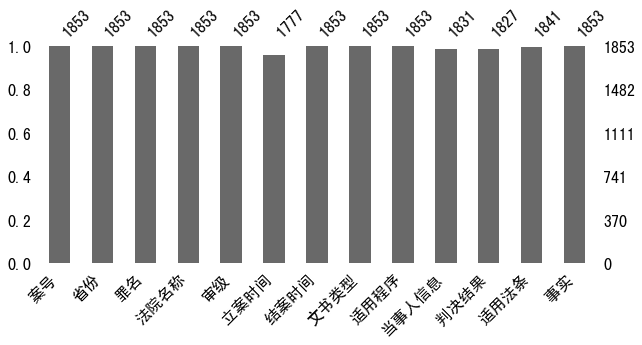

In [175]:
'''
from matplotlib.font_manager import _rebuild
_rebuild()
'''
#数据缺失情况(注意此前已经将fact为空的部分删去)
import missingno as msno
msno.bar(data,labels=True,figsize=(10,4),)

## 2. 事实部分文本分析

### 2.1 分词

In [203]:
fact = pd.DataFrame(data['事实'])

In [406]:
fact.head()

,string,words
0,"经审理查明:2015年7月起,被告人钟某某通过同案人胡某(已判决)学会了使用电脑木马病毒盗窃...","[经审, 理查, 同案, 胡某, 已判决, 电脑, 木马病毒, 盗窃, 游戏, 装备, 游戏..."
1,"经审理查明:(一)2016年7月起,被告人戴宝来为能够多推销公司装修业务创造营利,与被告人童...","[经审, 理查, 戴宝来, 能够, 推销, 公司, 装修, 业务, 创造, 营利, 童君莉,..."
2,"上述事实,被告人张宵、王战斌在庭审过程中亦无异议,并有同案犯孙昆、李某的供述,证人陈某的证言...","[上述事实, 张宵, 王战斌, 庭审, 异议, 同案犯, 孙昆, 李某, 供述, 证人, 陈..."
3,"上述事实,公诉机关当庭提供了相关证据,并据此认为被告人苏小永的行为已触犯《中华人民共和国刑法...","[上述事实, 当庭, 提供, 证据, 认为, 苏小永, 行为, 已触犯, 中华人民共和国, ..."
4,"经审理,二审查明的事实与原审一致。原判中列明的经庭审举证、质证认定本案事实的证据,具有合法性...","[审查, 一致, 中列明, 庭审, 举证, 质证, 本案, 证据, 合法性, 客观性, 关联..."


In [205]:
fact.columns=['string']

In [206]:
from __future__ import print_function, unicode_literals
import jieba
import jieba.analyse
jieba.load_userdict('law_dict.txt') #加入法律词典

In [469]:
fact['words']=''
# 对句子去除停用词
def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

def movestopwords(sentence):
    stopwords = stopwordslist('cn_stopwords.txt')  # 这里加载停用词的路径
    del_word = ['审理','查明','被告人','学会','使用','方法','一种','名为','过程','进行','最后', '一个','一名','一张','一共','上述','之前', '之后', '之间','两个',
             '公安局','公安机关','公安','公安民警','公诉机关','共同','共计','其亦有','具体','具有','内以','决定书','出生','出示','分局','分有','分给','刑事','刑事案件',
            '刑事责任年龄','刑事责任能力','刑法','判决','判决书','判处', '利用', '到案', '剩下', '办理', '功能','参与','另查明','后来','没有', '相关','上诉人', '提取', '经查',
            '缓刑','无异议','罪行','开庭审理','认定','原判','量刑','原审','事实','适用','建议','检查','决定','情况','提供','提出','不予','上诉','证明','同年','律师', '事务所律师',
            '辩护人', '户籍地', '文化', '户籍所在地','羁押','决定', '本院', '家住', '变更', '现押', '县公安局', '次日','非法', '依法逮捕','现住','指定辩护人']
    santi_words =[x for x in sentence if x not in stopwords and x not in del_word and not x.isdigit() and len(x)>1] #删去停用词,以及非男女性别的单字词 #(len(x) >1 or x in ['男','女']) and
    #santi_words =[x for x in sentence if x not in stopwords and not x.isdigit() and len(x)>1] 
    return santi_words

In [214]:
for i in range(fact.shape[0]):
    words = jieba.cut(fact.string[i])
    word_list = movestopwords(words) # 去除停用词
    #words_split = " ".join(word_list) #列表解析为字符串
    fact.words[i] = word_list
    #case.string[i] = words_split

<ipython-input-214-8113d2cab6f9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact.words[i] = word_list


### 2.2 建立词袋

In [65]:
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

In [216]:
dict_w = gensim.corpora.Dictionary(fact.words)

In [217]:
len(dict_w)

28491

In [ ]:
id_list = list(dict_w.id2token.keys())

In [234]:
id_list = list(dict_w.id2token.keys())
word_list = list(dict_w.id2token.values())
word_count_dict = {'word_id':id_list,'word':word_list}
word_count = pd.DataFrame(data=word_count_dict)

In [236]:
count = word_count['word_id'].apply((lambda x:dict_w.cfs[x]))

In [237]:
word_count['count'] = count

In [238]:
word_count

,word_id,word,count
0,0,1.4,7
1,1,13A,2
2,2,BiuBi,1
3,3,IPHONE,25
4,4,IPHONE6,4
...,...,...,...
28486,28486,谭浩退,1
28487,28487,防伪,4
28488,28488,案二审,1
28489,28489,滨州市,1


In [240]:
print(word_count.sort_values(by = 'count',axis = 0,ascending = False)['word'].head(100).tolist())

['个人信息', '信息', '予以', '非法', '供述', '证据', '证实', '规定', '本院', '意见', '数据', '获取', '处罚', '手机', '扣押', '辩护人', '采纳', '公司', '出售', '从轻', '侵犯', '行为', '笔录', '购买', '第一款', '记录', '依法', '情节', '微信', '第三款', '辩护', '情况', '系统', 'QQ', '提供', '指控', '证明', '账号', '中华人民共和国', '构成', '电子', '计算机信息', '成立', '清单', '如实', '公安', '证人', '证言', '本院认为', '犯罪', '人民币', '机关', '提出', '电脑', '获利', '违法所得', '支付宝', '工作', '交易', '上诉', '违反', '检查', '犯罪事实', '第六十七条', '照片', '归案', '不予', '庭审', '抓获', '理查', '软件', '三条', '罪名', '严重', '二百五十', '上述事实', '认罪', '第六十四', '经审', '查询', '特别', '本案', '说明', '客户', '有限公司', '游戏', '转账', '情节严重', '足以认定', '异议', '搜查', '账户', '李某', '期间', '价格', '决定', '王某', '截图', '辩解', '陈某']


In [703]:
word_count.sort_values(by = 'count',axis = 0,ascending = False).head(20)

,word_id,word,count
490,490,个人信息,9093
71,71,信息,7767
41,41,予以,4669
463,463,非法,4640
68,68,供述,4476
401,401,证据,4360
634,634,证实,4279
394,394,规定,4213
254,254,本院,3776
558,558,意见,3647


In [242]:
counts_group = word_count[['word','count']].groupby(['count']).count()

In [243]:
counts_group

,word
count,
1,12279
2,4075
3,1995
4,1418
5,1036
...,...
4476,1
4640,1
4669,1


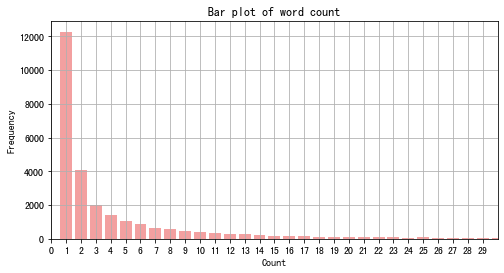

In [244]:
#画出各词频对应的单词数目条形图
import matplotlib.pyplot as plt
count_list = (word_count['count']).tolist()
#plt.hist(count_list,counts.shape[0], density=False, facecolor='g', alpha=0.75)
plt.bar(counts_group['word'].index,counts_group['word'].values, facecolor='lightcoral', alpha=0.75)
plt.rcParams['figure.figsize'] = (8, 4) 
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Bar plot of word count')
plt.xlim(1,30)
plt.xticks(range(30))
plt.grid(True)
plt.show()

### 2.3 建立LDA模型

In [245]:
dict_w.filter_extremes(no_below=2) 
corpus_w = [dict_w.doc2bow(doc) for doc in fact.words]

In [311]:
lda_m3=LdaModel(corpus=corpus_w, id2word=dict_w, num_topics=3,
                       passes = 100, random_state = 100)
lda_m4=LdaModel(corpus=corpus_w, id2word=dict_w, num_topics=4,
                       passes = 100, random_state = 100)
lda_m5=LdaModel(corpus=corpus_w, id2word=dict_w, num_topics=5,
                       passes = 100, random_state = 100)
lda_m8=LdaModel(corpus=corpus_w, id2word=dict_w, num_topics=8,
                       passes = 100, random_state = 100)
lda_m10=LdaModel(corpus=corpus_w, id2word=dict_w, num_topics=10,
                       passes = 100, random_state = 100)

In [320]:
lda_m4=LdaModel(corpus=corpus_w, id2word=dict_w, num_topics=4,
                       passes = 100, random_state = 100)

In [321]:
cm_4 = CoherenceModel(model=lda_m4, texts=fact.words, 
    dictionary=dict_w,  coherence='c_v')

In [ ]:
cm_3 = CoherenceModel(model=lda_m3, texts=fact.words, 
    dictionary=dict_w,  coherence='c_v')
cm_4 = CoherenceModel(model=lda_m4, texts=fact.words, 
    dictionary=dict_w,  coherence='c_v')
cm_5 = CoherenceModel(model=lda_m5, texts=fact.words,
    dictionary=dict_w,  coherence='c_v')
cm_8 = CoherenceModel(model=lda_m8, texts=fact.words, 
    dictionary=dict_w,  coherence='c_v')
cm_10 = CoherenceModel(model=lda_m10, texts=fact.words,
    dictionary=dict_w,  coherence='c_v')

In [322]:
print(cm_3.get_coherence())
print(cm_4.get_coherence())
print(cm_5.get_coherence())
print(cm_8.get_coherence())
print(cm_10.get_coherence())

0.4333012997516872
0.4456074846964282
0.4119802453690881
0.4911103188104809
0.48379037383331225


In [359]:
model = lda_m4
num_topics = 4 #尝试进行了10主题,但主题间重复过多,最终定为coherence较高的4主题.

In [324]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.font_manager import _rebuild
_rebuild()
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

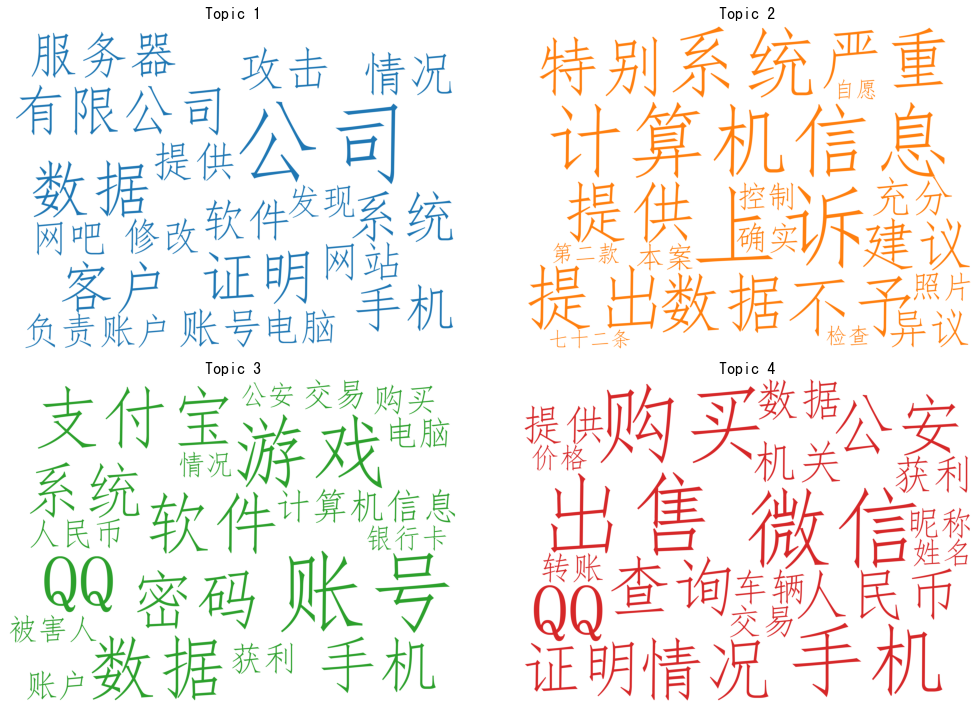

In [705]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
font = r'C:\Windows\Fonts\simfang.ttf'
#wc = WordCloud(collocations=False, font_path=font, width=1400, height=1400, margin=2).generate(text.lower())
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  font_path=font,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(formatted=False,num_words=20)

fig, axes = plt.subplots(2,2, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i > (num_topics-1):
        fig.add_subplot(ax)
        plt.gca().axis('off')
        continue
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [326]:
model.show_topics(num_words=10)

[(0,
  '0.028*"公司" + 0.010*"数据" + 0.009*"证明" + 0.009*"客户" + 0.008*"系统" + 0.008*"有限公司" + 0.007*"手机" + 0.007*"服务器" + 0.006*"情况" + 0.006*"攻击"'),
 (1,
  '0.014*"上诉" + 0.011*"计算机信息" + 0.010*"系统" + 0.009*"提出" + 0.008*"不予" + 0.008*"提供" + 0.007*"严重" + 0.007*"特别" + 0.007*"数据" + 0.007*"建议"'),
 (2,
  '0.020*"账号" + 0.015*"游戏" + 0.012*"QQ" + 0.011*"数据" + 0.011*"软件" + 0.011*"支付宝" + 0.010*"密码" + 0.009*"手机" + 0.008*"系统" + 0.008*"计算机信息"'),
 (3,
  '0.015*"出售" + 0.015*"微信" + 0.013*"购买" + 0.012*"手机" + 0.009*"QQ" + 0.008*"情况" + 0.008*"公安" + 0.007*"查询" + 0.007*"证明" + 0.007*"人民币"')]

指标的可视化

In [674]:
import pyLDAvis
import pyLDAvis.gensim

In [678]:
pyLDAvis.enable_notebook()
p_fact = pyLDAvis.gensim.prepare(model, corpus_w, dict_w)
p_fact

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.026024  0.114734       1        1  33.680916
1      0.194013 -0.069322       2        1  25.207409
0     -0.148723 -0.093335       3        1  21.709871
2     -0.071314  0.047923       4        1  19.401806, topic_info=     Term         Freq        Total Category  logprob  loglift
450    公司  2879.000000  2879.000000  Default  30.0000  30.0000
253    游戏  1177.000000  1177.000000  Default  29.0000  29.0000
363    账号  2263.000000  2263.000000  Default  28.0000  28.0000
716    上诉  1508.000000  1508.000000  Default  27.0000  27.0000
5      QQ  2402.000000  2402.000000  Default  26.0000  26.0000
..    ...          ...          ...      ...      ...      ...
230    机关   318.038239  1894.753296   Topic4  -5.4974  -0.1449
391  违法所得   297.825195  1614.882690   Topic4  -5.5630  -0.0507
185    提出   296.732361  1782.122559   Topic4  -5.5667  -0.1529
157    微信   285.174408  2496.866699   Topic4  -5.6064  -0.5299
639    出售   281.675537  2846.194092   Topic4  -5.6188  -0.6732

[339 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
4653      1  0.980627    AA
8498      3  0.987385   App
2167      2  0.056307  DDOS
2167      3  0.934689  DDOS
2574      1  0.025316  IP地址
...     ...       ...   ...
8261      2  0.988114   陈美华
7745      4  0.978654   陈鑫铭
7234      1  0.986852    露露
1922      1  0.992171    面积
5640      3  0.992545    马洁

[646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [336]:
prob = model.get_document_topics(corpus_w)

In [372]:
prob_list = []
for i in range(len(prob)):
#for i in range(10):
    list_i = [0 for i in range(num_topics)]
    topic_appeared = [pair[0] for pair in prob[i]]
    for j in range(len(topic_appeared)):
        list_i[topic_appeared[j]] = prob[i][j][1]
    prob_list.append(list_i)

In [383]:
#将每个fact对应各个主题的概率存储下来
fact_prob = pd.DataFrame(prob_list)
fact_prob.columns = ['fact_topic_'+str(i) for i in fact_prob.columns]
fact_prob.shape

(1853, 4)

## 3. 当事人信息文本分析

### 3.1分词

In [471]:
info = pd.DataFrame(data['当事人信息'])

In [472]:
info.head()

,当事人信息
0,"公诉机关湛江经济技术开发区人民检察院。被告人钟某某,绰号“蜻蜓”,男,1994年12月21日..."
1,"公诉机关浙江省桐庐县人民检察院。被告人戴宝来,男,1983年4月6日出生,汉族,文化程度高中..."
2,"公诉机关浙江省平阳县人民检察院。被告人张宵,男,1988年3月2日出生于山西省古交市,汉族,..."
3,"公诉机关浙江省苍南县人民检察院。被告人苏小永,男,1991年5月18日出生于甘肃省礼县,汉族..."
4,"原公诉机关浙江省松阳县人民检察院。上诉人(原审被告人)程海龙,男,1988年1月19日出生于..."


In [475]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   string  1831 non-null   string
 1   words   1853 non-null   object
dtypes: object(1), string(1)
memory usage: 29.1+ KB


In [473]:
info.columns=['string']
info['words'] = '0'
info['string'][info['string'].isna()] = '0'

In [486]:
info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1853 entries, 0 to 1852
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   string  1853 non-null   string
 1   words   1853 non-null   object
dtypes: object(1), string(1)
memory usage: 29.1+ KB


In [401]:
full_index = info.dropna(axis=0).index

In [487]:
#for i in full_index:
for i in range(len(info['words'])):
    words = jieba.cut(info.string[i])
    word_list = movestopwords(words) # 去除停用词
    #words_split = " ".join(word_list) #列表解析为字符串
    info.words[i] = word_list
    #case.string[i] = words_split

<ipython-input-487-87218e5e1b41>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info.words[i] = word_list


### 3.2 建立词袋

In [501]:
info_dict_w = gensim.corpora.Dictionary(info.words)

In [489]:
len(info_dict_w)

10618

In [ ]:
info_ito = info_dict_w.token2id
info_ito.keys()

In [519]:
info_id_list = list(info_ito.values())
info_word_list = list(info_ito.keys())
info_word_count_dict = {'word_id':info_id_list,'word':info_word_list}
info_word_count = pd.DataFrame(data=info_word_count_dict)

In [522]:
info_count = info_word_count['word_id'].apply((lambda x:info_dict_w.cfs[x]))
info_word_count['count'] = info_count
info_word_count

,word_id,word,count
0,0,人民检察院,1881
1,1,刑事拘留,3706
2,2,小学文化,214
3,3,居住地,94
4,4,广东省,1155
...,...,...,...
10613,10613,湘潭市,2
10614,10614,谭浩,1
10615,10615,雨湖区,1
10616,10616,鹿泉,1


In [523]:
print(info_word_count.sort_values(by = 'count',axis = 0,ascending = False)['word'].head(100).tolist())

['汉族', '刑事拘留', '取保候审', '逮捕', '因涉嫌', '本案', '看守所', '人民检察院', '浙江省', '个人信息', '羁押于', '侵犯', '浙江', '广东省', '罪于', '初中文化', '山东省', '程度', '大专文化', '无业', '杭州市', '广州市', '广东', '农民', '金华市', '高中文化', '山东', '有限公司', '大学', '系统', '计算机信息', '宁波市', '绍兴市', '中专文化', '务工', '日因', '同日', '深圳市', '抓获', '湖南省', '法律援助', '安徽省', '江苏省', '温州市', '河南省', '中心', '指派', '湖北省', '台州市', '江西省', '日经', '同月', '继续', '因犯', '人民法院', '东阳市', '曾用名', '青岛市', '河北省', '义乌市', '有期徒刑', '四川省', '福建省', '小学文化', '茂名市', '富阳', '苍南县', '员工', '余姚市', '慈溪市', '获取', '出生地', '瓯海区', '广西壮族自治区', '强制措施', '温岭市', '盗窃罪', '黑龙江省', '控制', '瑞安市', '佛山市', '数据', '舟山市', '白区', '诸暨市', '初中', '大学本科', '中山市', '处罚金', '诈骗罪', '北京市', '原系', '公司员工', '公司', '执行逮捕', '东莞市', '刑满释放', '日转', '婺城区', '被告']


In [704]:
info_word_count.sort_values(by = 'count',axis = 0,ascending = False).head(20)

,word_id,word,count
9,9,汉族,3862
1,1,刑事拘留,3706
24,24,取保候审,3034
18,18,逮捕,2180
49,49,因涉嫌,2147
8,8,本案,2092
12,12,看守所,2085
0,0,人民检察院,1881
38,38,浙江省,1609
110,110,个人信息,1558


In [526]:
info_counts_group = info_word_count[['word','count']].groupby(['count']).count()
info_counts_group

,word
count,
1,6560
2,1779
3,532
4,397
5,181
...,...
2147,1
2180,1
3034,1


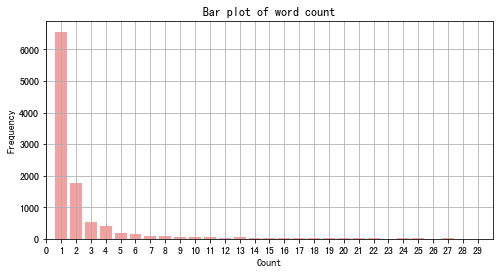

In [527]:
#画出各词频对应的单词数目条形图
import matplotlib.pyplot as plt
count_list = (info_word_count['count']).tolist()
#plt.hist(count_list,counts.shape[0], density=False, facecolor='g', alpha=0.75)
plt.bar(info_counts_group['word'].index,info_counts_group['word'].values, facecolor='lightcoral', alpha=0.75)
plt.rcParams['figure.figsize'] = (8, 4) 
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.title('Bar plot of word count')
plt.xlim(1,30)
plt.xticks(range(30))
plt.grid(True)
plt.show()

### 3.3 建立LDA

In [528]:
info_dict_w.filter_extremes(no_below=2) 
info_corpus_w = [info_dict_w.doc2bow(doc) for doc in info.words]

In [529]:
info_lda_m3=LdaModel(corpus=info_corpus_w, id2word=info_dict_w, num_topics=3,
                       passes = 100, random_state = 100)
info_lda_m4=LdaModel(corpus=info_corpus_w, id2word=info_dict_w, num_topics=4,
                       passes = 100, random_state = 100)
info_lda_m5=LdaModel(corpus=info_corpus_w, id2word=info_dict_w, num_topics=5,
                       passes = 100, random_state = 100)
info_lda_m8=LdaModel(corpus=info_corpus_w, id2word=info_dict_w, num_topics=8,
                       passes = 100, random_state = 100)
info_lda_m10=LdaModel(corpus=info_corpus_w, id2word=info_dict_w, num_topics=10,
                       passes = 100, random_state = 100)

In [530]:
info_cm_3 = CoherenceModel(model=info_lda_m3, texts=info.words, 
    dictionary=info_dict_w,  coherence='c_v')
info_cm_4 = CoherenceModel(model=info_lda_m4, texts=info.words, 
    dictionary=info_dict_w,  coherence='c_v')
info_cm_5 = CoherenceModel(model=info_lda_m5, texts=info.words,
    dictionary=info_dict_w,  coherence='c_v')
info_cm_8 = CoherenceModel(model=info_lda_m8, texts=info.words, 
    dictionary=info_dict_w,  coherence='c_v')
info_cm_10 = CoherenceModel(model=info_lda_m10, texts=info.words,
    dictionary=info_dict_w,  coherence='c_v')

In [541]:
info_lda_m6=LdaModel(corpus=info_corpus_w, id2word=info_dict_w, num_topics=6,
                       passes = 100, random_state = 100)
info_lda_m7=LdaModel(corpus=info_corpus_w, id2word=info_dict_w, num_topics=7,
                       passes = 100, random_state = 100)
info_cm_6 = CoherenceModel(model=info_lda_m6, texts=info.words,
    dictionary=info_dict_w,  coherence='c_v')
info_cm_7 = CoherenceModel(model=info_lda_m7, texts=info.words, 
    dictionary=info_dict_w,  coherence='c_v')
print(info_cm_6.get_coherence())
print(info_cm_7.get_coherence())

0.3148898149849214
0.3370667176960385


In [531]:
print(info_cm_3.get_coherence())
print(info_cm_4.get_coherence())
print(info_cm_5.get_coherence())
print(info_cm_8.get_coherence()) #八类时信息略有冗余
print(info_cm_10.get_coherence())

0.2900462520858424
0.2983043655655
0.3094959107545845
0.3581277849568121
0.3384332555188185


由于八个topic时信息出现冗余,选取coherence同样相对较高的7主题模型.

In [554]:
info_model = info_lda_m7
info_num_topics = 7

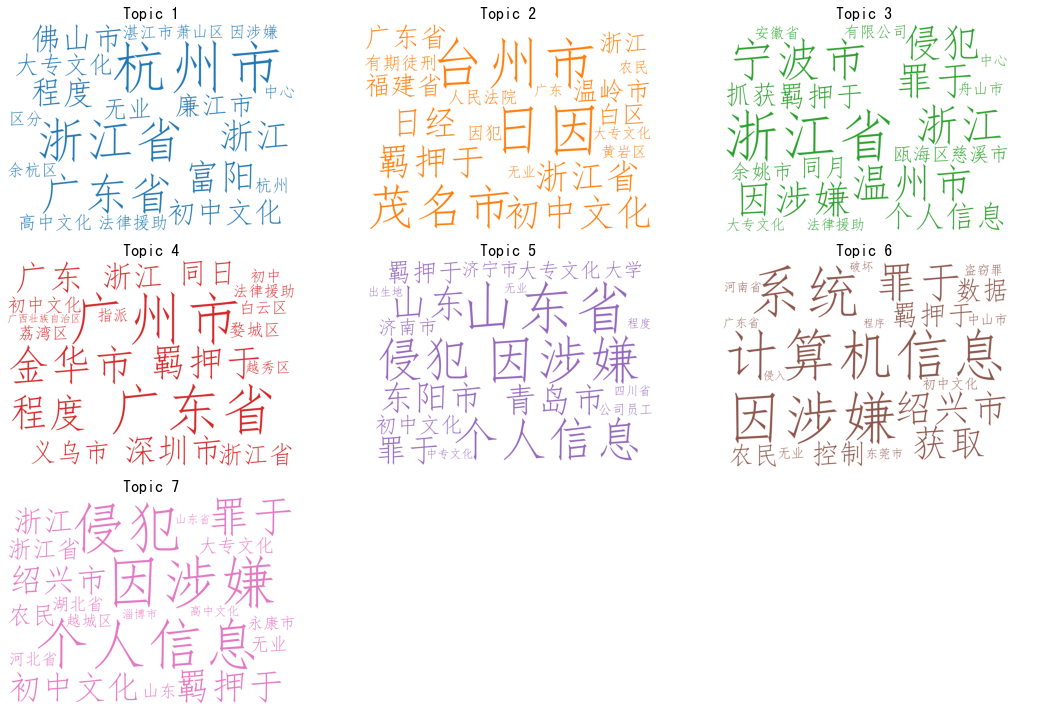

In [555]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
font = r'C:\Windows\Fonts\simfang.ttf'
#wc = WordCloud(collocations=False, font_path=font, width=1400, height=1400, margin=2).generate(text.lower())
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  font_path=font,
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = info_model.show_topics(formatted=False,num_words=20)

fig, axes = plt.subplots(3,3, figsize=(15,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i > (info_num_topics-1):
        fig.add_subplot(ax)
        plt.gca().axis('off')
        continue
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [556]:
info_model.show_topics(num_words=10)

[(0,
  '0.077*"杭州市" + 0.055*"浙江省" + 0.043*"广东省" + 0.027*"富阳" + 0.027*"浙江" + 0.022*"程度" + 0.020*"佛山市" + 0.017*"初中文化" + 0.015*"廉江市" + 0.013*"大专文化"'),
 (1,
  '0.036*"日因" + 0.035*"台州市" + 0.025*"茂名市" + 0.025*"初中文化" + 0.024*"羁押于" + 0.022*"浙江省" + 0.021*"日经" + 0.021*"广东省" + 0.019*"温岭市" + 0.018*"福建省"'),
 (2,
  '0.061*"浙江省" + 0.037*"宁波市" + 0.035*"浙江" + 0.029*"温州市" + 0.027*"罪于" + 0.026*"因涉嫌" + 0.026*"侵犯" + 0.026*"个人信息" + 0.023*"羁押于" + 0.019*"抓获"'),
 (3,
  '0.046*"广州市" + 0.043*"广东省" + 0.042*"金华市" + 0.035*"程度" + 0.033*"羁押于" + 0.027*"广东" + 0.025*"深圳市" + 0.022*"浙江" + 0.020*"同日" + 0.016*"义乌市"'),
 (4,
  '0.066*"山东省" + 0.053*"因涉嫌" + 0.044*"个人信息" + 0.043*"侵犯" + 0.028*"山东" + 0.022*"东阳市" + 0.022*"青岛市" + 0.019*"罪于" + 0.017*"羁押于" + 0.012*"初中文化"'),
 (5,
  '0.060*"因涉嫌" + 0.058*"系统" + 0.058*"计算机信息" + 0.032*"罪于" + 0.024*"绍兴市" + 0.024*"获取" + 0.023*"羁押于" + 0.022*"控制" + 0.020*"数据" + 0.018*"农民"'),
 (6,
  '0.069*"因涉嫌" + 0.067*"个人信息" + 0.065*"侵犯" + 0.037*"罪于" + 0.025*"羁押于" + 0.020*"初中文化" + 0.020*"绍兴市" + 0.017*"浙江" + 0

In [676]:
p_info = pyLDAvis.gensim.prepare(info_model, info_corpus_w, info_dict_w)
p_info

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.208181 -0.062800       1        1  17.706160
6      0.144898  0.024760       2        1  16.585957
4      0.167347  0.073164       3        1  15.914366
2      0.003042  0.161759       4        1  15.795073
1     -0.094718 -0.145271       5        1  12.359370
0     -0.150903  0.124416       6        1  11.027349
5      0.138515 -0.176027       7        1  10.611726, topic_info=     Term         Freq        Total Category  logprob  loglift
154   杭州市   542.000000   542.000000  Default  30.0000  30.0000
62    山东省   815.000000   815.000000  Default  29.0000  29.0000
34    因涉嫌  2046.000000  2046.000000  Default  28.0000  28.0000
83     侵犯  1456.000000  1456.000000  Default  27.0000  27.0000
80    广州市   527.000000   527.000000  Default  26.0000  26.0000
..    ...          ...          ...      ...      ...      ...
225    广东    70.096237   519.933350   Topic7  -4.5759   0.2394
30   中专文化    52.173969   368.959473   Topic7  -4.8712   0.2871
35   大专文化    56.527878   660.074524   Topic7  -4.7911  -0.2144
23     浙江    58.496643  1211.921875   Topic7  -4.7568  -0.7878
62    山东省    49.418274   815.834045   Topic7  -4.9255  -0.5607

[438 rows x 6 columns], token_table=      Topic      Freq Term
term                      
3190      3  0.940616   一丁
227       1  0.128793   一年
227       2  0.287307   一年
227       3  0.009907   一年
227       4  0.089164   一年
...     ...       ...  ...
896       1  0.915621  龙岗区
896       3  0.072286  龙岗区
489       5  0.985576  龙岩市
392       6  0.983504  龙泉市
253       4  0.974997  龙湾区

[712 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 7, 5, 3, 2, 1, 6])

In [679]:
pyLDAvis.save_html(p_fact, 'lda_fact.html')
pyLDAvis.save_html(p_info, 'lda_info.html')

In [557]:
info_prob = info_model.get_document_topics(info_corpus_w)

In [558]:
info_prob_list = []
for i in range(len(info_prob)):
#for i in range(10):
    list_i = [0 for i in range(info_num_topics)]
    topic_appeared = [pair[0] for pair in info_prob[i]]
    for j in range(len(topic_appeared)):
        list_i[topic_appeared[j]] = info_prob[i][j][1]
    info_prob_list.append(list_i)

In [559]:
info_prob = pd.DataFrame(info_prob_list)

In [560]:
info_prob.columns = ['info_topic_'+str(i) for i in info_prob.columns]

In [561]:
info_prob.shape

(1853, 7)

In [562]:
info_prob.head()

,info_topic_0,info_topic_1,info_topic_2,info_topic_3,info_topic_4,info_topic_5,info_topic_6
0,0.622771,0.000000,0.083638,0.000000,0.000000,0.260419,0.000000
1,0.000000,0.000000,0.000000,0.984652,0.000000,0.000000,0.000000
2,0.000000,0.109748,0.000000,0.000000,0.000000,0.470399,0.402998
3,0.011991,0.011959,0.012013,0.910062,0.011927,0.011930,0.011961
4,0.000000,0.660962,0.000000,0.000000,0.261688,0.000000,0.068513


In [563]:
info_prob.describe()

,info_topic_0,info_topic_1,info_topic_2,info_topic_3,info_topic_4,info_topic_5,info_topic_6
count,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000
mean,0.145142,0.119459,0.137200,0.216658,0.142604,0.083366,0.135230
std,0.277325,0.243135,0.277453,0.327545,0.274289,0.190896,0.252698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.010234,0.000000,0.000000,0.000000
75%,0.142857,0.080949,0.089255,0.393760,0.137972,0.015933,0.144227
max,0.993686,0.997155,0.997814,0.995355,0.998180,0.995385,0.997975


## 4. 利用LDA 提取的文本特征聚类

以上我们对'当事人信息'与'事实'这两个信息丰富的文本数据提取了主题Topic,分别得到了4个和7个指标,且均为连续型变量,适合进行K-Means聚类.

In [564]:
feature = pd.concat([fact_prob,info_prob],axis=1)

In [565]:
feature.head()

,fact_topic_0,fact_topic_1,fact_topic_2,fact_topic_3,info_topic_0,info_topic_1,info_topic_2,info_topic_3,info_topic_4,info_topic_5,info_topic_6
0,0.000000,0.000000,0.999242,0.000000,0.622771,0.000000,0.083638,0.000000,0.000000,0.260419,0.000000
1,0.510624,0.000000,0.000000,0.488436,0.000000,0.000000,0.000000,0.984652,0.000000,0.000000,0.000000
2,0.000000,0.992046,0.000000,0.000000,0.000000,0.109748,0.000000,0.000000,0.000000,0.470399,0.402998
3,0.000000,0.126875,0.000000,0.871644,0.011991,0.011959,0.012013,0.910062,0.011927,0.011930,0.011961
4,0.000000,0.920141,0.074492,0.000000,0.000000,0.660962,0.000000,0.000000,0.261688,0.000000,0.068513


In [566]:
feature.shape

(1853, 11)

In [572]:
#尝试聚类
from sklearn.cluster import KMeans
from sklearn import metrics
#计算silhouette_score与类内方差inertias
range_n_clusters = [i for i in range(2,21)]
results = []
inertias = []
for c in range_n_clusters:
    kmeans = KMeans(init='k-means++',n_clusters=c,n_init=100,random_state=0)
    cluster_labels = kmeans.fit_predict(feature)
    silhouette_avg = metrics.silhouette_score(feature,cluster_labels)
    results.append([c,silhouette_avg])
    inertias.append(kmeans.inertia_) #Sum of squared distances of samples to their closest cluster center.
result = pd.DataFrame(results,columns=['n_clusters','silhouette_score'])
pivot = pd.pivot_table(result,index='n_clusters',values='silhouette_score')

In [573]:
#计算一类时类内方差，作为方差百分比的分母
kmeans_1 = KMeans(init='k-means++',n_clusters=1,n_init=100,random_state=0)
label_1 = kmeans_1.fit_predict(feature)
total = round(kmeans_1.inertia_)

In [574]:
percent = (np.round(inertias))/total

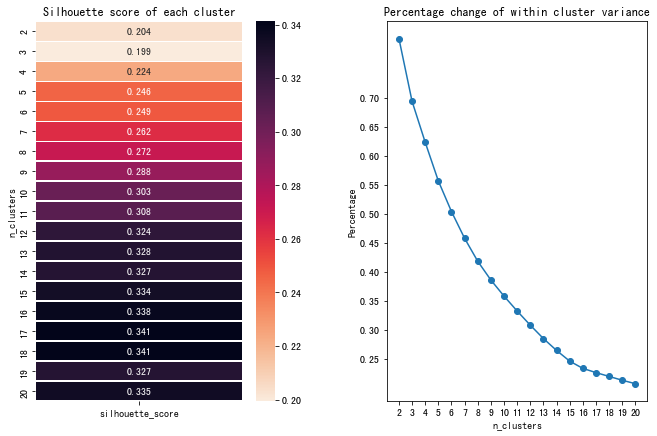

In [577]:
#作图
import seaborn as sns
plt.figure()
plt.rcParams['figure.figsize'] = (10,10) 
plt.subplots_adjust(wspace=20)
plt.subplot(121)
sns.heatmap(pivot,annot=True,linewidths=0.5,fmt='.3f',cmap=sns.cm.rocket_r)
plt.title('Silhouette score of each cluster')
plt.tight_layout()
plt.subplot(122)
plt.plot(range_n_clusters,percent,marker='o')
plt.xticks(range_n_clusters)
plt.yticks([0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70])
plt.title('Percentage change of within cluster variance')
plt.xlabel('n_clusters')
plt.ylabel('Percentage')
plt.show()

可以看出,根据silhouette得分与方差下降速率的综合结果,选取15类较为合适.

In [579]:
kmeans_15 = KMeans(init='k-means++',n_clusters=15,n_init=100,random_state=0)
labels = pd.DataFrame(kmeans_15.fit(feature).labels_)
clustered_data = pd.DataFrame(feature).assign(Cluster=labels)
clustered_data.head()

,fact_topic_0,fact_topic_1,fact_topic_2,fact_topic_3,info_topic_0,info_topic_1,info_topic_2,info_topic_3,info_topic_4,info_topic_5,info_topic_6,Cluster
0,0.000000,0.000000,0.999242,0.000000,0.622771,0.000000,0.083638,0.000000,0.000000,0.260419,0.000000,0
1,0.510624,0.000000,0.000000,0.488436,0.000000,0.000000,0.000000,0.984652,0.000000,0.000000,0.000000,5
2,0.000000,0.992046,0.000000,0.000000,0.000000,0.109748,0.000000,0.000000,0.000000,0.470399,0.402998,4
3,0.000000,0.126875,0.000000,0.871644,0.011991,0.011959,0.012013,0.910062,0.011927,0.011930,0.011961,5
4,0.000000,0.920141,0.074492,0.000000,0.000000,0.660962,0.000000,0.000000,0.261688,0.000000,0.068513,14


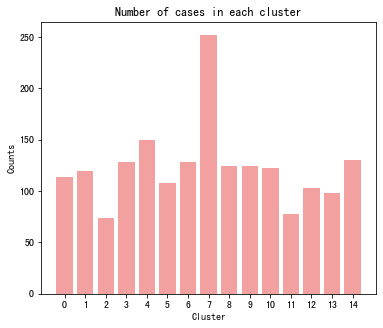

In [582]:
import collections
label_count = collections.Counter(kmeans_15.labels_)
label_count = label_count.most_common()
df_label = pd.DataFrame(label_count)
df_label.columns = ['cluster','count']
df_label = df_label.sort_values(by='cluster',ascending=True).reset_index(drop=True)
fig,ax = plt.subplots()
plt.rcParams['figure.figsize'] = (6,5) 
plt.bar(df_label['cluster'],df_label['count'],facecolor='lightcoral', alpha=0.75)
plt.xlabel('Cluster')
plt.ylabel('Counts')
plt.title('Number of cases in each cluster')
ax.set_xticks(range(15))
plt.show()

In [590]:
#各类中心点
centers = kmeans_15.cluster_centers_
center_topic =[]
for i in range(len(centers)):
    topic_list = []
    topic_list.append(np.argmax(centers[i][0:4]))
    topic_list.append(np.argmax(centers[i][4:11]))
    center_topic.append(topic_list)

In [594]:
pd.DataFrame(center_topic,columns=['fact_topic','info_topic'],index=['Cluster'+str(i) for i in range(15)])

,fact_topic,info_topic
Cluster0,2,3
Cluster1,1,0
Cluster2,0,3
Cluster3,1,4
Cluster4,1,5
Cluster5,3,3
Cluster6,3,6
Cluster7,1,3
Cluster8,3,0
Cluster9,1,2


可见,根据LDA所提取的主题,样本被聚成了15类.

## 5. word2vec聚类

### 5.1 采用中文预训练词向量模型

这里采用GitHub标星8k的中文预训练300维的词向量模型,搜集自各大新闻网页与百度百科等平台,更贴合法律文书分析.  
https://github.com/Embedding/Chinese-Word-Vectors![image.png](attachment:image.png)  
但意外的是,该词向量模型对于本案例的数据集并未带来提升,可能是因为部分法律词汇在原文本集中并未以恰当的方式衡量,造成"水土不服".

In [250]:
pre_train = stopwordslist('sgns.merge.word')

In [252]:
#from gensim.models.word2vec import KeyedVectors
from gensim.models import KeyedVectors
wv_from_text = KeyedVectors.load_word2vec_format('sgns.merge.word', binary=False)

In [271]:
print(r"'微信', '支付宝'的词向量间相似度为: ",wv_from_text.similarity('支付宝','微信'))
print(r"'银行卡', '密码'的词向量间相似度为: ",wv_from_text.similarity('银行卡','密码'))
print(r"'网吧', '服务器'的词向量间相似度为: ",wv_from_text.similarity('网吧','服务器'))

'微信', '支付宝'的词向量间相似度为:  0.6163013
'银行卡', '密码'的词向量间相似度为:  0.42664036
'微信', 'QQ'的词向量间相似度为:  0.44300342


In [255]:
wv_from_text.syn0.std()

<ipython-input-255-dc96ca33afa6>:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  wv_from_text.syn0.std()


0.20791432

In [595]:
w2v = pd.DataFrame(fact['words']+info['words']) #由于采用预训练的词向量模型,因此二者不必分开处理
#w2v['words'] = fact.words

In [601]:
#将词向量存储至vec列
w2v['vec'] = [[] for i in range(w2v.shape[0])]
drop_case = []
for i in range(len(w2v['vec'])):
    vec_list = []
    #vec_list = [model_w2v.wv[token] for token in case.words[i]]
    for token in w2v.words[i]:
        #这里由于未对词频为1的词予以考虑，当在model_w2v.wv查询不到时会发出异常，这里catch到异常后进入下一轮循环
        try: 
            token_vec = wv_from_text.wv[token]
            vec_list.append(token_vec)
        except(KeyError):
            continue
    
    if vec_list:
        mean_vec = (np.mean(vec_list,axis=0)).tolist() #取均值作为每个case新的向量
        w2v['vec'][i] = (w2v['vec'][i])+(mean_vec)
    else:
        drop_case.append(i) #vec_list为空，表明该文本不具有c词向量预训练的词汇，后续进行删除

<ipython-input-601-a8d43e92b2da>:10: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  token_vec = wv_from_text.wv[token]


In [602]:
w2v

,words,vec
0,"[经审, 理查, 同案, 胡某, 已判决, 电脑, 木马病毒, 盗窃, 游戏, 装备, 游戏...","[0.10161897540092468, 0.03882720693945885, 0.0..."
1,"[经审, 理查, 戴宝来, 能够, 推销, 公司, 装修, 业务, 创造, 营利, 童君莉,...","[0.03314141556620598, 0.03103737346827984, -0...."
2,"[上述事实, 张宵, 王战斌, 庭审, 异议, 同案犯, 孙昆, 李某, 供述, 证人, 陈...","[0.11670494079589844, 0.026810288429260254, -0..."
3,"[上述事实, 当庭, 提供, 证据, 认为, 苏小永, 行为, 已触犯, 中华人民共和国, ...","[0.08787157386541367, 0.04671362414956093, -0...."
4,"[审查, 一致, 中列明, 庭审, 举证, 质证, 本案, 证据, 合法性, 客观性, 关联...","[0.12797752022743225, -0.008274917490780354, -..."
...,...,...
1848,"[经审, 理查, 月份, 贷款, 公司, 期间, 获得, 客户资源, 先后, 多次, 上线,...","[0.09488210827112198, 0.04634637385606766, -0...."
1849,"[经审, 理查, 证据, 指控, 一致, 本院认为, 焦晨阳, 行为, 构成, 非法, 控制...","[0.09334556013345718, 0.05534306541085243, -0...."
1850,"[经审, 理查, 谭浩, 得知, 东阿, 阿胶, 胶员, 购买, 东阿, 阿胶, 防伪, 录...","[0.10022394359111786, 0.03598220646381378, -0...."
1851,"[经审, 理查, 本院认为, 任某, 李某, 违反, 国家有关, 规定, 合法经营, 活动,...","[0.13443134725093842, 0.020110057666897774, -0..."


In [604]:
print(drop_case) #查看是否有需要删除的列,暂无

[]


In [606]:
df_vec = pd.DataFrame(w2v.vec.values.tolist())
df_vec.tail() #300维词向量

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
1848,0.094882,0.046346,-0.114045,0.019717,-0.084142,0.123591,0.036657,0.190418,0.128728,0.258779,...,0.249413,-0.070914,-0.294092,0.242772,-0.054448,-0.073549,-0.150293,0.176471,-0.039110,-0.122047
1849,0.093346,0.055343,-0.161025,0.033260,-0.035299,0.183450,-0.021420,0.240083,0.122811,0.254044,...,0.242606,-0.031451,-0.257287,0.226003,-0.091303,-0.086862,-0.185114,0.154691,0.009400,-0.146515
1850,0.100224,0.035982,-0.056916,0.040516,-0.073706,0.125361,0.082434,0.181216,0.090180,0.276618,...,0.299708,-0.042389,-0.250967,0.213659,-0.048228,-0.076290,-0.183376,0.100467,-0.029253,-0.151760
1851,0.134431,0.020110,-0.193212,-0.006320,-0.085741,0.224020,0.049760,0.239204,0.126267,0.318283,...,0.213174,-0.115002,-0.357885,0.245079,-0.128649,-0.119937,-0.188537,0.133458,-0.087987,-0.155122
1852,0.011157,0.047739,-0.163928,0.103927,-0.042791,0.138469,0.017608,0.186733,0.123604,0.234634,...,0.196111,-0.061087,-0.289974,0.246688,-0.079327,-0.077717,-0.166255,0.162391,0.038501,-0.080203


In [607]:
#尝试聚类
from sklearn.preprocessing import StandardScaler
df_vec = StandardScaler().fit_transform(df_vec) #数据标准化

###  5.2 尝试聚类

In [608]:
#计算silhouette_score与类内方差inertias
range_n_clusters = [i for i in range(2,21)]
results = []
inertias = []
for c in range_n_clusters:
    kmeans = KMeans(init='k-means++',n_clusters=c,n_init=100,random_state=0)
    cluster_labels = kmeans.fit_predict(df_vec)
    silhouette_avg = metrics.silhouette_score(df_vec,cluster_labels)
    results.append([c,silhouette_avg])
    inertias.append(kmeans.inertia_) #Sum of squared distances of samples to their closest cluster center.
result = pd.DataFrame(results,columns=['n_clusters','silhouette_score'])
pivot = pd.pivot_table(result,index='n_clusters',values='silhouette_score')

In [609]:
#计算一类时类内方差，作为方差百分比的分母
kmeans_1 = KMeans(init='k-means++',n_clusters=1,n_init=100,random_state=0)
label_1 = kmeans_1.fit_predict(df_vec)
total = round(kmeans_1.inertia_)

In [610]:
percent = (np.round(inertias))/total

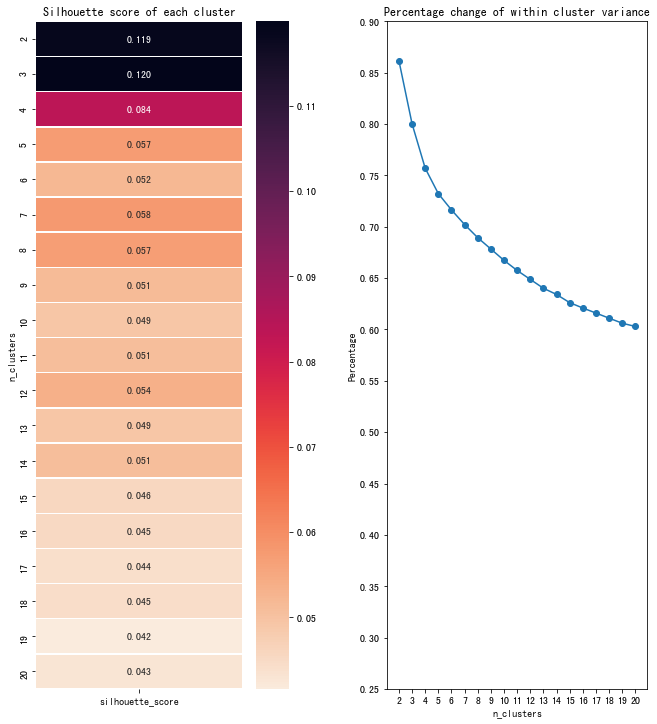

In [615]:
#作图
import seaborn as sns
plt.figure()
plt.rcParams['figure.figsize'] = (10,10) 
plt.subplots_adjust(wspace=20)
plt.subplot(121)
sns.heatmap(pivot,annot=True,linewidths=0.5,fmt='.3f',cmap=sns.cm.rocket_r)
plt.title('Silhouette score of each cluster')
plt.tight_layout()
plt.subplot(122)
plt.plot(range_n_clusters,percent,marker='o')
plt.xticks(range_n_clusters)
plt.yticks([0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90])
plt.title('Percentage change of within cluster variance')
plt.xlabel('n_clusters')
plt.ylabel('Percentage')
plt.show()

可以看到,该模型聚类效果并不好,类内方差的占比持续高于60%,聚类并未较好地分离特征.

### 5.3 自行训练

fact与info分开训练,再拼接

In [652]:
from gensim.models import Word2Vec
fact_w2v = Word2Vec(fact.words, size=100, min_count=5) #仅考虑词频在2以上的词汇
info_w2v = Word2Vec(info.words, size=100, min_count=5) #仅考虑词频在2以上的词汇

In [653]:
fact_wv = fact_w2v.wv
info_wv = fact_w2v.wv

In [654]:
#将词向量存储至vec列
fact['vec'] = [[] for i in range(fact.shape[0])]
info['vec'] = [[] for i in range(info.shape[0])]
drop_case = []
for i in range(len(fact['vec'])):
    vec_list1 = []
    vec_list2 = []
    #vec_list = [model_w2v.wv[token] for token in case.words[i]]
    for token in fact.words[i]:
        #这里由于未对词频为1的词予以考虑，当在model_w2v.wv查询不到时会发出异常，这里catch到异常后进入下一轮循环
        try: 
            token_vec = fact_w2v.wv[token]
            vec_list1.append(token_vec)
        except(KeyError):
            continue
    for token in info.words[i]:
        #这里由于未对词频为1的词予以考虑，当在model_w2v.wv查询不到时会发出异常，这里catch到异常后进入下一轮循环
        try: 
            token_vec = info_w2v.wv[token]
            vec_list2.append(token_vec)
        except(KeyError):
            continue
    
    if vec_list1:
        mean_vec1 = (np.mean(vec_list1,axis=0)).tolist() #取均值作为每个case新的向量
        fact['vec'][i] = (fact['vec'][i])+(mean_vec1)
    else:
        drop_case.append(i) #vec_list为空，表明该文本不具有词频在2以上的词汇，后续进行删除
        
    if vec_list2:
        mean_vec2 = (np.mean(vec_list2,axis=0)).tolist() #取均值作为每个case新的向量
        info['vec'][i] = (info['vec'][i])+(mean_vec2)
    else:
        drop_case.append(i) #vec_list为空，表明该文本不具有词频在2以上的词汇，后续进行删除

<ipython-input-654-3a0a5afbbdb0>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fact['vec'][i] = (fact['vec'][i])+(mean_vec1)
<ipython-input-654-3a0a5afbbdb0>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info['vec'][i] = (info['vec'][i])+(mean_vec2)


In [655]:
train_vec = pd.DataFrame((fact['vec']+info['vec']).values.tolist())

In [656]:
train_vec.drop(drop_case,inplace=True)
train_vec = train_vec.reset_index(drop=True)
#print('Now there are ',train_vec.shape[0],'cases left.')

Now there are  1831 cases left.


In [657]:
train_vec.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.019650,-0.334590,-0.027069,0.379508,-0.161478,-0.002194,-0.754240,-0.218971,-0.244996,-0.496401,...,0.267973,0.167137,-0.021937,0.202570,-0.327139,-0.209114,0.402898,-0.380760,-0.332101,-0.038797
1,0.391604,-0.323060,-0.002649,0.242491,-0.113467,0.385406,-0.321318,0.091648,-0.101627,0.342352,...,0.590723,0.140163,-0.046951,0.486427,-0.751392,-0.271842,0.100023,0.077804,-0.543086,0.478883
2,-0.077550,-0.489538,-0.180960,0.762479,-0.118803,-0.493420,-0.599297,0.115080,-0.064808,-0.183629,...,0.237057,-0.275785,-0.018732,-0.209354,-0.531730,-0.263614,0.272235,-0.190010,-0.537848,0.267432
3,0.137235,-0.580196,-0.195675,0.377285,-0.368372,0.146955,-0.385452,0.103763,-0.196729,0.413497,...,0.432898,0.153805,-0.051470,0.319505,-0.625427,-0.256706,0.238671,-0.144654,-0.361606,0.181958
4,-0.286243,-0.524156,-0.401850,0.582226,-0.294640,-0.601971,-0.112969,0.329159,-0.093578,-0.148290,...,0.308970,0.072208,-0.111527,0.208107,-0.467740,-0.223899,0.238521,-0.200434,-0.366628,0.127575


In [658]:
from sklearn.preprocessing import StandardScaler
train_vec = StandardScaler().fit_transform(train_vec) #数据标准化

In [659]:
#计算silhouette_score与类内方差inertias
range_n_clusters = [i for i in range(2,21)]
results = []
inertias = []
for c in range_n_clusters:
    kmeans = KMeans(init='k-means++',n_clusters=c,n_init=100,random_state=0)
    cluster_labels = kmeans.fit_predict(train_vec)
    silhouette_avg = metrics.silhouette_score(train_vec,cluster_labels)
    results.append([c,silhouette_avg])
    inertias.append(kmeans.inertia_) #Sum of squared distances of samples to their closest cluster center.
result = pd.DataFrame(results,columns=['n_clusters','silhouette_score'])
pivot = pd.pivot_table(result,index='n_clusters',values='silhouette_score')

In [660]:
#计算一类时类内方差，作为方差百分比的分母
kmeans_1 = KMeans(init='k-means++',n_clusters=1,n_init=100,random_state=0)
label_1 = kmeans_1.fit_predict(df_vec)
total = round(kmeans_1.inertia_)

In [661]:
percent = (np.round(inertias))/total

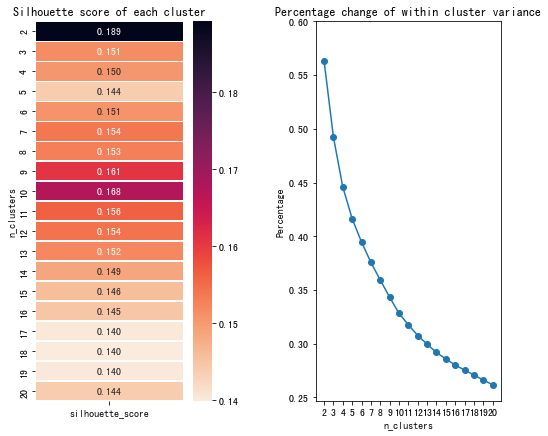

In [710]:
#作图
import seaborn as sns
plt.figure()
plt.rcParams['figure.figsize'] = (6,6) 
plt.subplots_adjust(wspace=20)
plt.subplot(121)
sns.heatmap(pivot,annot=True,linewidths=0.5,fmt='.3f',cmap=sns.cm.rocket_r)
plt.title('Silhouette score of each cluster')
plt.tight_layout()
plt.subplot(122)
plt.plot(range_n_clusters,percent,marker='o')
plt.xticks(range_n_clusters)
plt.yticks([0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60])
plt.title('Percentage change of within cluster variance')
plt.xlabel('n_clusters')
plt.ylabel('Percentage')
plt.show()

综合两指标,选取10类进行聚类

In [663]:
kmeans_10 = KMeans(init='k-means++',n_clusters=10,n_init=100,random_state=0)
labels = pd.DataFrame(kmeans_10.fit(train_vec).labels_)
clustered_data = pd.DataFrame(train_vec).assign(Cluster=labels)
clustered_data.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Cluster
0,-0.132850,0.455117,1.161840,-1.127557,0.186824,0.689942,-1.283694,-1.348232,-1.626850,-1.991199,...,1.080585,0.625283,0.093073,1.207760,0.137686,1.217746,-1.130137,1.033845,-1.046068,8
1,1.683908,0.511185,1.306910,-1.845398,0.438866,1.882035,0.184682,0.293009,-0.647815,1.230243,...,0.941531,0.357931,1.546114,-1.733101,-1.223072,-1.610341,1.925285,-0.731025,1.786463,1
2,-0.607614,-0.298342,0.247626,0.878839,0.410852,-0.820862,-0.758159,0.416817,-0.396389,-0.789918,...,-1.202701,0.659541,-2.015526,-0.210436,-1.044581,-0.002319,0.140831,-0.687212,0.629492,0
3,0.441476,-0.739184,0.160211,-1.139203,-0.899293,1.148661,-0.032845,0.357021,-1.297246,1.503494,...,1.011855,0.309623,0.691652,-0.859928,-0.894718,-0.315721,0.443039,0.787041,0.161811,1
4,-1.626947,-0.466678,-1.064605,-0.065510,-0.512226,-1.154718,0.891356,1.547961,-0.592851,-0.654189,...,0.591220,-0.332287,0.121417,0.233133,-0.183043,-0.317122,0.071377,0.745031,-0.135746,7


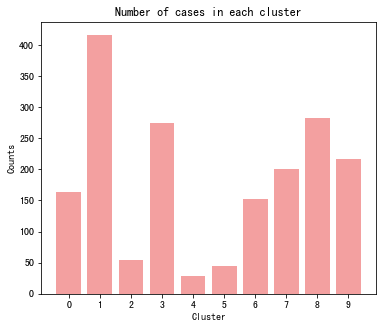

In [665]:
import collections
label_count = collections.Counter(kmeans_10.labels_)
label_count = label_count.most_common()
df_label = pd.DataFrame(label_count)
df_label.columns = ['cluster','count']
df_label = df_label.sort_values(by='cluster',ascending=True).reset_index(drop=True)
fig,ax = plt.subplots()
plt.rcParams['figure.figsize'] = (6,5) 
plt.bar(df_label['cluster'],df_label['count'],facecolor='lightcoral', alpha=0.75)
plt.xlabel('Cluster')
plt.ylabel('Counts')
plt.title('Number of cases in each cluster')
ax.set_xticks(range(10))
plt.show()

In [666]:
#各类中心点
centers = kmeans_10.cluster_centers_
center_similar =[]
for i in range(len(centers)):
    similar_list = []
    fact_pairs = fact_wv.most_similar(positive=[centers[i][0:100]],negative=[], topn=20)
    info_pairs = info_wv.most_similar(positive=[centers[i][100:200]],negative=[], topn=20)
    list1=[]
    list2=[]
    for j in range(len(fact_pairs)):
        list1.append(fact_pairs[j][0])
        list2.append(info_pairs[j][0])
    similar_list.append(list1)
    similar_list.append(list2)
    #topic_list.append(np.argmax(centers[i][4:11]))
    center_similar.append(similar_list)

In [668]:
df_center_sim = pd.DataFrame(center_similar,columns=['fact','info'],index=['Cluster'+str(i) for i in range(10)])

In [669]:
df_center_sim

,fact,info
Cluster0,"[姜成, 勒索, 入侵, SAAS, 修改, 操作, 计算机, 计算机系统, 木马程序, 程...","[SAAS, 自动, 系统, 身份验证, 蔡昭福, 破坏, 修改, 刘其, 控制, 关键, ..."
Cluster1,"[某锋, 取自, 名录, 常见问题, 贴文, 等值, 制作, 结论, 发给, 收到, 订单,...","[四条, 第二十五条, 第六十五条, 第六十七条, 第四十二条, 二款, 第三款, 第三十一..."
Cluster2,"[解释, 刑事诉讼法, 第一项, 第一百五十, 八条, 第五项, 第十五条, 第十一条, 第...","[修改, SAAS, 接警, 自动, 某炎, 郑元淼, 开发票, 帮助, 蒋朝辉, 抖音, ..."
Cluster3,"[四哥, 某锋, 取自, 收到, azellty, 赵有, 发给, 常见问题, 名录, 加其...","[数据, 曾理伟, 该份, 梁山, 检查, 电子, 有原, 蔡小红, 勘验, 备忘录, 证物..."
Cluster4,"[北苑, 发现, 地点, 手持, 备忘录, 梁公, 移动硬盘, 家中, 资料, 警方, 签认...","[成立, 梁赟, 有毒, 侵犯, 得罪, 应予, 支持, 人犯, 应予以, 惩罚, 惩处, ..."
Cluster5,"[葛传亮, 处罚金, 葛利兵, 六个月, 兰兰, 因犯, 具结, 唐天, 有期徒刑, 被判,...","[内容, 张凯凯, 含有, 王海博, 表格, 条数, 王红琴, 打印, EXCEL, 涉及,..."
Cluster6,"[幅度, 诈骗罪, 郑辉, 原则, 修正案, 应当, 法定, 综上, 并无不当, 中华人民共...","[数据, 曾理伟, 该份, 蔡小红, 电子, 勘验, 刻录成, 检查, 梁山, 系统, 复函..."
Cluster7,"[郑辉, 诈骗罪, 本罪, 修正案, 幅度, 刑事责任, 盗窃罪, 原则, 三百六十, 陈贤...","[凡友俊, 第二十七条, 摘录, 要求, 第四款, 第二十六条, 第六十五条, 第三十一条,..."
Cluster8,"[常见问题, 取自, 梁公, 资料, 画面, 备忘录, 指认, 截图, 某锋, 名录, 详单...","[赵某, 凡友俊, 某烨, 经营, 组织, 工资, 表弟, 马某, 服务站, 某卫, 小夜,..."
Cluster9,"[詹志明, 张洪超, 归案, 某艳, 甘某, 金鸿霞, 李志, 邓军普, 当庭, 属实, 后...","[黄静, 查获, 刘锋, 张凯凯, 剔除, 审讯, 随案, 天刚, 取证, 条数, 童永星,..."


In [711]:
print(df_center_sim['fact']['Cluster0'])
print(df_center_sim['info']['Cluster0'])

['姜成', '勒索', '入侵', 'SAAS', '修改', '操作', '计算机', '计算机系统', '木马程序', '程序', '测试数据', 'fiddle', '尚百信', '波尔', '隐蔽', '功能性', '服务器', '刘其', '控制软件', '免刷']
['SAAS', '自动', '系统', '身份验证', '蔡昭福', '破坏', '修改', '刘其', '控制', '关键', '郑元淼', '操作', '增加', '蒋朝辉', '网络设备', '客户机', '获取数据', '具备', '正常', '后果严重']


这一个Cluster大概是讲网络犯罪的程序技术操作.

In [673]:
print(df_center_sim['fact']['Cluster6'])
print(df_center_sim['info']['Cluster6'])

['幅度', '诈骗罪', '郑辉', '原则', '修正案', '应当', '法定', '综上', '并无不当', '中华人民共和国', '所犯', '刑事责任', '二百八十', '盗窃罪', '刑罚', '本罪', '区别', '建议', '陈贤平', '本次']
['数据', '曾理伟', '该份', '蔡小红', '电子', '勘验', '刻录成', '检查', '梁山', '系统', '复函', '视听资料', '勘察', '公海', '光盘', '网提', '备忘录', '刻录', '证物', '有原']


这一个Cluster大概是讲网络犯罪的数据刻录操作.

词向量的模型解释性远远不如LDA模型.